In [1]:
# from https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm,skew
# limiting the float to 3 
pd.set_option("display.float_format",lambda x:'{:.3f}'.format(x))

In [3]:
train = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')

In [4]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
# drop Id columns 
print('The train dataset size is {}'.format(train.shape))
print('The test dataset size is {}'.format(test.shape))
train_ID = train['Id']
test_ID  = test['Id']
train    = train.drop('Id',axis=1)
test     = test.drop('Id',axis=1)
print('The train dataset size is {}'.format(train.shape))
print('The test dataset size is {}'.format(test.shape))

The train dataset size is (1460, 81)
The test dataset size is (1459, 80)
The train dataset size is (1460, 80)
The test dataset size is (1459, 79)


## 1.outlier  - 离散值/异常值处理

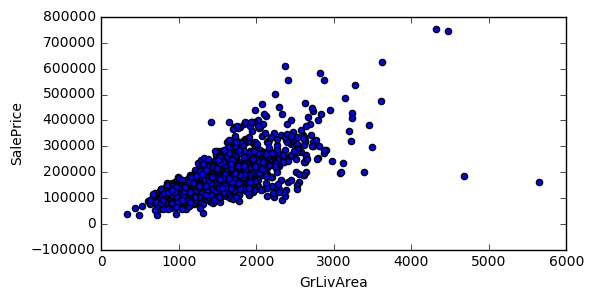

In [6]:
## 1.outlier  - 离散值/异常值处理
# GrLivArea: Above grade (ground) living area square feet - 地上生活面积
fig,ax = plt.subplots(figsize=(6,3))
ax.scatter(x = train['GrLivArea'], y= train['SalePrice'])
plt.xlabel('GrLivArea',size =10)
plt.ylabel('SalePrice',size =10)
plt.show()

In [7]:
###　右臂那的两个值GrLivArea　很大，对应的SalePrice却很小，这样的异常值可以去掉
index2 = train[(train['SalePrice']<=300000) & (train['GrLivArea']>=4000)].index
train  = train.drop(index2)

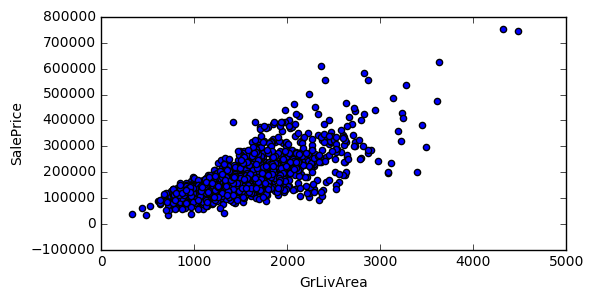

In [8]:
fig,ax = plt.subplots(figsize=(6,3))
ax.scatter(x = train['GrLivArea'], y= train['SalePrice'])
plt.xlabel('GrLivArea',size =10)
plt.ylabel('SalePrice',size =10)
plt.show()

对于异常值，并不是所有的异常值都要去掉，因为去掉所有的异常值会影响模型的robust 性能；与其全部去掉不如更好的管理这些数据

## 2目标变量的分析 - SalePrice 

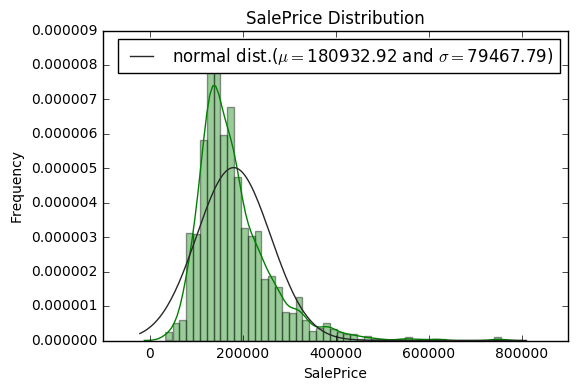

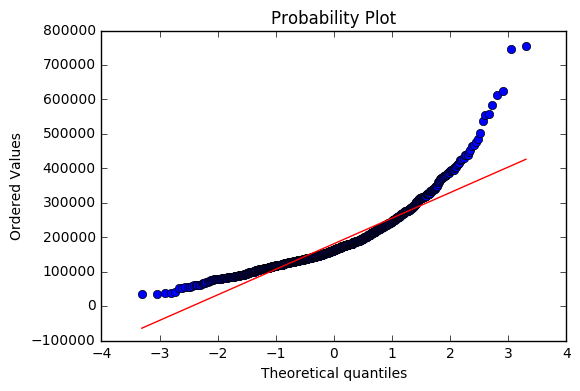

In [9]:
sns.distplot(train['SalePrice'],fit = norm,color = 'g')
(mu,sigma) = norm.fit(train['SalePrice'])
plt.legend(['normal dist.($\mu = ${:.2f} and $\sigma = ${:.2f})'.format(mu,sigma)],loc= 'best')
plt.ylabel("Frequency")
plt.title("SalePrice Distribution")
fig = plt.figure()
res = stats.probplot(train['SalePrice'],plot = plt)
plt.show()

上面的类似整体分布的角度是向右偏执的，线性模型更喜欢整体分布的数据，下面通过log将数据准换以获得更标准的正态分布数据

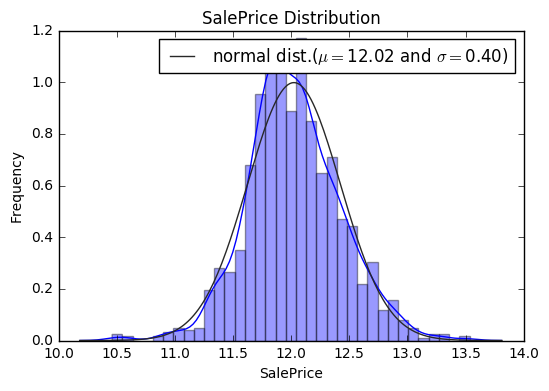

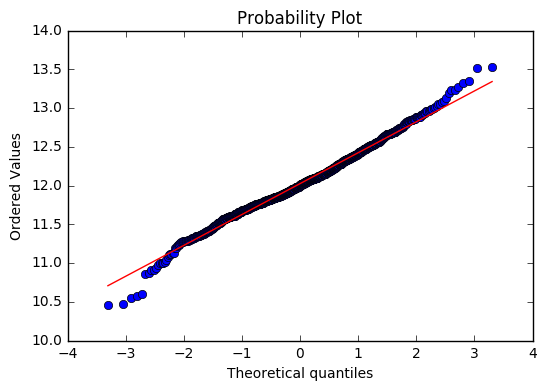

In [10]:
# np.log1p() 对有偏的数据进行转换 ，使其获得更标准的高斯分布
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'],fit = norm,color = 'b')
(mu,sigma) = norm.fit(train['SalePrice'])
plt.legend(['normal dist.($\mu = ${:.2f} and $\sigma = ${:.2f})'.format(mu,sigma)],loc= 'best')
plt.ylabel("Frequency")
plt.title("SalePrice Distribution")
fig = plt.figure()
res = stats.probplot(train['SalePrice'],plot = plt)
plt.show()

上面的数据通过矫正后可以看出更加符合正态分布 - 数据更加规整

## 3 特征工程

In [11]:
## 将数据拼接
ntrain = train.shape[0]
ntest  = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train,test)).reset_index(drop=True)
all_data.drop(['SalePrice'],axis=1,inplace = True)
print('all_data size is {}'.format(all_data.shape))

all_data size is (2917, 79)


## 3.1 Missing Data

In [12]:
# 3.1 Missing Data
all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({"Missing Rate:%":all_data_na})

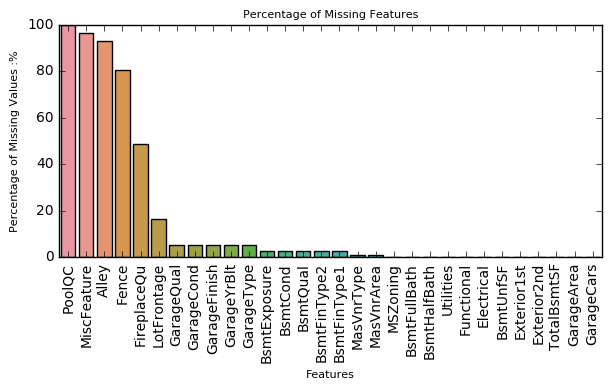

In [13]:
f,ax = plt.subplots(figsize=(7,3))
plt.xticks(rotation = '90')
sns.barplot(x = all_data_na.index,y = all_data_na)
plt.xlabel('Features',size =8)
plt.ylabel('Percentage of Missing Values :%',size = 8)
plt.title('Percentage of Missing Features',size = 8)
plt.show()

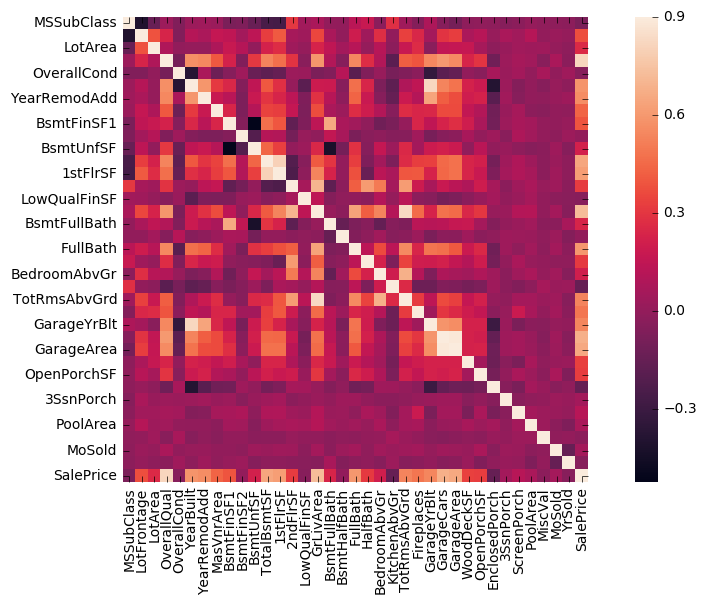

In [14]:
## 数据的相关计算 ；
corrmat = train.corr()
plt.subplots(figsize =(12,6))
sns.heatmap(data = corrmat,vmax = 0.9,annot = False,square = True) # annot - 方格上显示数字
plt.show()

## 3.2对缺失数据的处理

In [15]:
# PoolQC: Pool quality  - 大部分的房子都没有POOL 游泳池- 所以对于丢失的数据填写None-也是正常
#       Ex	Excellent
#       Gd	Good
#       TA	Average/Typical
#       Fa	Fair
#       NA	No Pool
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

In [16]:
# MiscFeature - Miscellaneous feature not covered in other categories
#       Elev	Elevator
#       Gar2	2nd Garage (if not described in garage section)
#       Othr	Other
#       Shed	Shed (over 100 SF)
#       TenC	Tennis Court
#       NA	None
#　 这个特征大部分的数据都丢失了，现在填写NA
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

In [17]:
# Alley: Type of alley access to property
#       Grvl	Gravel
#       Pave	Paved
#       NA 	No alley access
all_data['Alley'] = all_data['Alley'].fillna('None')

In [18]:
# Fence: Fence quality 
#       GdPrv	Good Privacy
#       MnPrv	Minimum Privacy
#       GdWo	Good Wood
#       MnWw	Minimum Wood/Wire
#       NA	No Fence
all_data['Fence'] = all_data['Fence'].fillna('None')

In [19]:
# FireplaceQu: Fireplace quality
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

In [20]:
# LotFrontage: Linear feet of street connected to property # 
# 距离物业距离相似或者相等的 房子可以认为是邻居 
# 所以这里对 要参考特征: 'Neighborhood'
#median_values = all_data.groupby('Neighborhood')['LotFrontage'].median()
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

In [21]:
## Some feature about Garage if data type is category can fill missing with NOne
# if data type is int/float can fill missing values with 0
for categorytype in ['GarageType','GarageFinish','GarageQual','GarageCond']:
    all_data[categorytype] = all_data[categorytype].fillna('None')

In [22]:
for enumerictype in ['GarageYrBlt','GarageCars','GarageArea']:
    all_data[enumerictype] = all_data[enumerictype].fillna(0)

In [23]:
## Some features are category need fill missing values with None 
for category in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']:
    all_data[category] = all_data[category].fillna('None')

In [24]:
for jint in ['BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']:
    all_data[jint] =  all_data[jint].fillna(0)

In [25]:
# MasVnrType and MasVnrArea Missing values 
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')

In [26]:
#MSZoning: Identifies the general zoning classification of the sale.
#all_data['MSZoning'].value_counts()
fillin = all_data['MSZoning'].value_counts().index[0]
all_data['MSZoning'] = all_data['MSZoning'].fillna(fillin)

In [27]:
# Utilities: Type of utilities available
all_data['Utilities'].value_counts(),all_data['Utilities'].unique(),all_data['Utilities'].isnull().sum()

(AllPub    2914
 NoSeWa       1
 Name: Utilities, dtype: int64,
 array(['AllPub', 'NoSeWa', nan], dtype=object),
 2)

In [28]:
# 上面的特征 - Utilities 有2个缺失值，1个NoSeWa,大部分都是‘AllPub’ - 这列特征对模型预测没有贡献 - 可以drop掉
all_data = all_data.drop('Utilities',axis = 1)

In [29]:
# Functional - Home functionality (Assume typical unless deductions are warranted)
#        Typ	Typical Functionality
#       Min1	Minor Deductions 1
#       Min2	Minor Deductions 2
#       Mod	Moderate Deductions
#       Maj1	Major Deductions 1
#       Maj2	Major Deductions 2
#       Sev	Severely Damaged
#       Sal	Salvage only
all_data['Functional'].value_counts()

Typ     2715
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

In [30]:
all_data['Functional'] = all_data['Functional'].fillna('Type')

In [31]:
#Electrical: Electrical system
#       SBrkr	Standard Circuit Breakers & Romex
#       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
#       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
#       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
#       Mix	Mixed
all_data['Electrical'].value_counts()

SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [32]:
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')

In [33]:
# Exterior1st  and Exterior2nd
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0]) # all_data['Exterior1st'].mode()[0]:众数
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) # all_data['Exterior1st'].mode()[0]:众数

In [34]:
# BsmtFinSF1 and BsmtFinSF2
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].fillna(all_data['BsmtFinSF1'].mode()[0])
all_data['BsmtFinSF2'] = all_data['BsmtFinSF2'].fillna(all_data['BsmtFinSF2'].mode()[0])

In [36]:
# KitchenQual: Kitchen quality
#Ex	Excellent
#       Gd	Good
#       TA	Typical/Average
#       Fa	Fair
#       Po	Poor
all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA')

In [37]:
# SaleType 
#SaleType: Type of sale
		
#       WD 	Warranty Deed - Conventional
#       CWD	Warranty Deed - Cash
#       VWD	Warranty Deed - VA Loan
#       New	Home just constructed and sold
#       COD	Court Officer Deed/Estate
#       Con	Contract 15% Down payment regular terms
#       ConLw	Contract Low Down payment and low interest
#       ConLI	Contract Low Interest
#       ConLD	Contract Low Down
#       Oth	Other
all_data['SaleType'] = all_data['SaleType'].fillna('WD')

In [38]:
# 还有下面的两个特征是缺少数据的
[index for index in all_data.isnull().sum().index if all_data.isnull().sum()[index]!=0]

[]

In [39]:
[index for index in all_data.isnull().sum().index if all_data.isnull().sum()[index]!=0] # 返回空说明没有缺失的特征了
all_data['MSSubClass'].isnull().sum()

0

In [40]:
def DistinguishCate(dataframe):
    isdigit,notdigit = [],[]
    column = dataframe.columns
    for _ in column:
        items = dataframe[_].unique()
        for item in items:
            if str(item).isdigit():
                isdigit.append(_) # is digit
                break
            else:
                notdigit.append(_) # is not digit 
                break
    return isdigit,notdigit

In [41]:
digitfeatures,notdigitfeatures = DistinguishCate(all_data) # 先区分数字特征还是不是数字特征

## 4 进一步的特征工程

In [42]:
all_data['OverallCond'] = all_data['OverallCond'].astype(str) # change from numeric to str

In [43]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str) # change from numeric to str

In [44]:
# YrSold and MoSold numeric to str 
all_data['YrSold'] = all_data['YrSold'].astype(str) # change from numeric to str
all_data['MoSold'] = all_data['MoSold'].astype(str) # change from numeric to str

In [45]:
# 对下面总类特征进行  Label Encoding 转成数字
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
lbl = LabelEncoder()
for col in cols:
    values_ = list(all_data[col].values)
    lbl.fit(values_)
    all_data[col] = lbl.transform(values_)
print('all_data shape is :{}'.format(all_data.shape))

all_data shape is :(2917, 78)


In [46]:
## 由于房屋的面积在预测房价时候是很重要的因素，现在新建一个新的特征 TotalSF
all_data['TotalSF'] = all_data['1stFlrSF'] + all_data['2ndFlrSF'] + all_data['TotalBsmtSF']

## 4.1 Skewed features - 向右边倾斜的特征

In [47]:
numeric_features = all_data.dtypes[all_data.dtypes!='object'].index # 数字列特征
skewed_features  = all_data[numeric_features].apply(lambda x:skew(x.dropna())).sort_values(ascending = False)
skewed_features_df = pd.DataFrame({'Skew':skewed_features})
skewed_features_df.head(4)

,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085


In [48]:
## 通过 Box Cox Transformation 对高Skew值的特征 进行转换
# 利用上次朋友函数 boxcox1p 计算 1+x的Box Cox Transformation
# 如果lambda = 1 == log1p
skewness = skewed_features_df[abs(skewed_features_df)>0.75]
print('there are {} features to BOx Cox transforming '.format(skewness.shape[0]))

there are 59 features to BOx Cox transforming 


In [49]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.5 
for feature in skewed_features:
    all_data[feature] = boxcox1p(all_data[feature],lam )

In [50]:
## getting dummines category features 
all_data = pd.get_dummies(all_data)
print('The shape of feature is {}'.format(all_data.shape))

The shape of feature is (2917, 220)


In [76]:
all_data.head(2)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,EnclosedPorch,ExterCond,ExterQual,Fence,FireplaceQu,Fireplaces,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenAbvGr,KitchenQual,LandSlope,LotArea,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,MoSold,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,...,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,56.549,56.481,0.000,0.828,2.000,2.472,2.000,51.179,0.000,1.464,3.292,0.828,0.000,1.464,22.576,0.828,0.000,2.472,1.464,2.472,2.000,0.000,1.464,3.292,44.861,1.464,2.899,1.464,2.899,87.532,80.728,0.828,0.000,0.828,1.464,0.000,181.859,14.248,2.000,0.000,4.633,26.071,0.000,2.472,13.748,2.472,3.657,1.464,0.000,2.000,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
1,69.077,0.000,0.000,0.828,2.000,2.472,0.828,60.578,0.000,0.000,3.292,0.000,0.828,1.464,31.764,0.828,0.000,2.472,2.000,2.472,2.899,0.828,1.464,3.292,40.942,1.464,2.899,1.464,2.899,86.927,69.077,0.000,0.000,0.828,2.000,0.000,193.969,16.000,2.000,0.000,2.899,0.000,0.000,3.657,0.000,3.657,3.292,1.464,0.000,2.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


In [51]:
# getting the new train and test data
train = all_data[:ntrain]
test  = all_data[ntrain:]
print('The shape of train data is {}'.format(train.shape))
print('The shape of test is {}'.format(test.shape))

The shape of train data is (1458, 220)
The shape of test is (1459, 220)


## 5 Modeling

In [52]:
from sklearn.linear_model import ElasticNet,Lasso,BayesianRidge,LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor 
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone
from sklearn.model_selection import KFold,cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb 
import lightgbm as lgb

In [53]:
## 5.1 定义交叉验证
n_folds = 5 
def rmsle_cv(model):
    kf = KFold(n_folds,shuffle = True,random_state = 2020).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model,train.values,y_train,scoring = 'neg_mean_squared_error',cv = kf))
    return rmse

## 5.2 Base model

In [54]:
# LASSO Model = 对异常的数据比较敏感 - 为了让模型在这些数据上更加robust,添加pipeline 如下
lasso = make_pipeline(RobustScaler(),Lasso(alpha = 0.0005,random_state = 2020))

In [55]:
## Elastic Net Regression
ENet = make_pipeline(RobustScaler(),ElasticNet(alpha = 0.0005,l1_ratio = 0.9,random_state = 2020))

In [56]:
# Kernal Ridge regession 
KPR = KernelRidge(alpha = 0.6,kernel = 'polynomial',degree = 2,coef0=2.5)

In [57]:
# Gradient Boosting Regression 
GBoost = GradientBoostingRegressor(
    n_estimators = 3000,
    learning_rate = 0.05,
    max_depth = 4,
    max_features = 'sqrt',
    min_samples_leaf = 15,
    min_samples_split = 10,
    loss = 'huber',random_state =2020
)

In [58]:
# Xgboost 
model_xgb = xgb.XGBRegressor(colsample_bytree = 0.4603,
                gamma= 0.0468,
                             learning_rate= 0.05,max_depth=3,
                             min_child_weight = 1.7817,n_estimators = 2200,
                             reg_alpha = 0.4640,reg_lambda = 0.8571,
                             subsample = 0.5231,silent = 1,random_state = 2020,nthread = -1
                            )

In [59]:
# LightGBM
model_gbm = lgb.LGBMRegressor(
    objective='regression',num_leaves = 5,learning_rate=0.05,n_estimators = 720,max_bin  = 55, bagging_fraction =0.8,
    bagging_freq = 5,feature_fraction = 0.2319,
    feature_fraction_seed = 9, bagging_seed = 9,
    min_data_in_leaf = 6,min_sum_hessian_in_leaf = 11

)

## 5.3 scores of model 

In [60]:
score = rmsle_cv(lasso)
print("lasso socre             is {:.4f}({:.4f})".format(score.mean(),score.std()))
score = rmsle_cv(ENet)
print("ENet socre              is {:.4f}({:.4f})".format(score.mean(),score.std()))

score = rmsle_cv(KPR)
print("Kernal Ridge socre      is {:.4f}({:.4f})".format(score.mean(),score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting socre is {:.4f}({:.4f})".format(score.mean(),score.std()))

score = rmsle_cv(model_xgb)
print("XGboost socre           is {:.4f}({:.4f})".format(score.mean(),score.std()))
score = rmsle_cv(model_gbm)
print("LGBM socre              is {:.4f}({:.4f})".format(score.mean(),score.std()))

lasso socre             is 0.1108(0.0067)
ENet socre              is 0.1108(0.0068)
Kernal Ridge socre      is 0.1546(0.0141)
Gradient Boosting socre is 0.1157(0.0079)
XGboost socre           is 0.1162(0.0060)
LGBM socre              is 0.1151(0.0069)


## 5.4 Stacking Model

In [61]:
# using the simple approach of average model 
# Average base model class 
class AverageModles(BaseEstimator,RegressorMixin,TransformerMixin):
    def __init__(self,models):
        self.models = models
    # we define the clones of original models to fit the data
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.models]
        # train cloned based models
        for model in self.models_:
            model.fit(X,y)
        return self
    # now we do the prediction for cloned moddel and average them
    def predict(self,X):
        predictions = np.column_stack([
                model.predict(X) for model in  self.models_
            ])
        return np.mean(predictions,axis=1)

In [62]:
# here we just average the model: ENet,Gboost,KPR,and lasso
average_Models = AverageModles(models = (ENet,GBoost,KPR,lasso))
scores_ave     = rmsle_cv(average_Models)
print("Average socre is {:.4f}({:.4f})".format(scores_ave.mean(),scores_ave.std()))
print('### 上面的简单的求均值后模型的性能有些许的提升')

Average socre is 0.1106(0.0090)
### 上面的简单的求均值后模型的性能有些许的提升


In [63]:
class StackingAveragedModels2(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [64]:
class StackingAverMOdels(BaseEstimator,RegressorMixin,TransformerMixin):
    def __init__(self,base_modes,meta_model,n_folds = 5):
        self.base_modes = base_modes
        self.meta_model = meta_model
        self.n_folds = n_folds
    # we again fit the data on the clone model from original model
    def fit(self,X,y):
        self.base_modes_ =[list() for x in self.base_modes]
        self.meta_model_ =clone(self.meta_model)
        kfold = KFold(n_splits = self.n_folds ,shuffle = True,random_state = 2020)
            
        # trian clone basd model and then create the out-of-fold predictions that needed to train the meta-model
        out_of_fold_predictons = np.zeros((X.shape[0],len(self.base_modes)))
        for i,model in enumerate(self.base_modes):
            for train_index,holdout_index in kfold.split(X,y):
                instance = clone(model)
                self.base_modes_[i].append(instance)
                instance.fit(X[train_index],y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictons[holdout_index,i] = y_pred
        # train the cloned meta-model using the outof - fold predictions 
        self.meta_model_.fit(out_of_fold_predictons,y)
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([np.column_stack([model.predict(X) for model in base_modes]).mean(axis=1) 
                                         for base_modes in self.base_modes_ ])
        return self.meta_model_.predict(meta_features)
    
AverModel          = StackingAverMOdels(base_modes = (ENet,GBoost,KPR), meta_model = lasso)
scores_AverModel   = rmsle_cv(AverModel)
print("StackingAverMOdels average socre is {:.4f}({:.4f})".format(scores_AverModel.mean(),scores_AverModel.std()))

StackingAverMOdels average socre is 0.1081(0.0071)


In [65]:
# 为了比较两种方法，这里平均 Enet KRR and Gboost and add lasso as the meta-model 
Stackavg_models = StackingAveragedModels2(base_models = (ENet,GBoost,KPR), meta_model = lasso)
scores_ave2     = rmsle_cv(Stackavg_models)
print("StackingAveragedModels2:average2 score is {:.4f}({:.4f})".format(scores_ave2.mean(),scores_ave2.std()))

StackingAveragedModels2:average2 score is 0.1083(0.0070)


## 上面的方法让我们的性能有了进一步的提升

In [66]:
# 集成 StackedRegressor,XGBoost and LightGBM
# We added XGBoost and LightGBM to the StackedRegressor
# define one rmsle evalution function 
def rmsle(y,y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

In [79]:
#test.isnull().sum()

In [67]:
# stackRegressor:
AverModel.fit(train.values,y_train)
stack_train_pred = AverModel.predict(train.values)
stack_pred       = np.expm1(AverModel.predict(test.values))
print(rmsle(y_train,stack_train_pred))

0.07938551859536448


In [68]:
# Xgboost
model_xgb.fit(train.values,y_train)
xgb_train_pred = model_xgb.predict(train.values)
xgb_pred = np.expm1(model_xgb.predict(test.values))
print(rmsle(y_train,xgb_train_pred))

0.07838491333629592


In [69]:
# lightGBM
model_gbm.fit(train.values,y_train)
lgb_train_pred = model_gbm.predict(train.values)
lgb_pred = np.expm1(model_gbm.predict(test.values))
print(rmsle(y_train,lgb_train_pred))

0.07210084277592503


In [70]:
# rmse one the entrie train data when averaging 
print('RMSLE score on the train data is :')
print(rmsle(y_train,stack_train_pred*0.7 + xgb_train_pred*0.15 + 0.15*lgb_train_pred))

RMSLE score on the train data is :
0.07612035662339978


In [71]:
# Ensemble prediction 
Ensemble_pred = stack_pred*0.7 + 0.15*xgb_pred+0.15*lgb_pred
Ensemble_pred

array([119597.58175064, 154287.09291229, 185728.03907724, ...,
       166986.38919079, 117200.93415231, 221606.76408712])

In [73]:
# Submission
sub = pd.DataFrame()
sub['ID'] = test_ID
sub['SalePrice']  = Ensemble_pred
sub.to_csv('./data/SubmissionsToKaggle.csv',index = False,header= True) # 0.11643

In [75]:
print("THe score on the Kaggle LB is ",100*939/5385,'%')

THe score on the Kaggle LB is  17.43732590529248 %
